In [16]:
from ftplib import FTP
from io import BytesIO
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
from astropy.io import fits
import astropy.units as u

In [2]:
# Function to download spectrum from FTP
def download_spectrum_ftp(url):
    from urllib.parse import urlparse

    parsed_url = urlparse(url)
    ftp_host = parsed_url.hostname
    ftp_file_path = parsed_url.path

    ftp = FTP(ftp_host)
    ftp.login()

    file_data = BytesIO()
    ftp.retrbinary(f"RETR {ftp_file_path}", file_data.write)
    ftp.quit()

    file_data.seek(0)
    return file_data.read()

# Intrinsic luminosity dictionary
intrinsic_lum = {
    'O5': 846000, 'O9': 95000,
    'B0': 20000, 'B1': 4600,
    'A0': 22, 'A2': 18,
    'F0': 4.3, 'F2': 3.3,
    'G0': 1.3, 'G2': 1,
    'K0': 0.54, 'K2': 0.38,
    'M0': 0.069, 'M1': 0.064
}

# Spectra URLs dictionary with explicit spectral type mapping
spectra_urls = {
    "O5": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
    "O9": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits",
    "B0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
    "B1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits",
    "A0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
    "A2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits",
    "F0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
    "F2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits",
    "G0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
    "G2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits",
    "K0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
    "K2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits",
    "M0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
    "M1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
}

# Download the spectra data
spectra = {key: download_spectrum_ftp(url) for key, url in spectra_urls.items()}

In [3]:
# Masas para categorizar Estrellas
def Mclassifier(mass):
    if mass > 16:
        return "O"
    elif mass > 2.1:
        return "B"
    elif mass > 1.4:
        return "A"
    elif mass > 1.04:
        return "F"
    elif mass > 0.8:
        return "G"
    elif mass > 0.45:
        return "K"
    else:
        return "M"
    
# DISCRTEIZAR A 14 GYR, cambiar esto, como elegimos esta edad
universe_age = 14


def lum(mass):
    if mass > 55:
        return 3200 * mass
    elif mass > 2:
        return mass ** 4
    elif mass > 0.43:
        return 1.4 * mass ** 3.5
    else:
        return 0.23 * mass ** 2.3
 

def STARage(mass):
    #returns: time in SP, estimated age

    def SP_time(mass):
        sp_Sun = 10.0
        return sp_Sun / (mass ** 3)
    
    if mass > 5:
        return SP_time(mass), SP_time(mass)
    else: 
        return SP_time(mass) , SP_time(mass) + 1.1


spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

def read_spectrum_from_fits(data):
    with fits.open(BytesIO(data)) as hdul:
        spectrum_data = hdul[0].data
        header = hdul[0].header
        wavelengths = np.arange(header['CRVAL1'], header['CRVAL1'] + header['CDELT1'] * len(spectrum_data), header['CDELT1'])
        return wavelengths[:len(spectrum_data)], spectrum_data

# OCUPA LOS ESPECTROS REALES
def get_star_spectrum(spectral_type):
    if spectral_type in spectra:
        data = spectra[spectral_type][0]
        wavelengths, spectrum = read_spectrum_from_fits(data)
        return wavelengths, spectrum
    else:
        raise ValueError(f"Spectral type {spectral_type} not available in spectra.")
    

# Function to calculate the total luminosity of the spectrum
def tot_lum(wavelength, spectrum):
    luminosity = np.trapz(spectrum, x=wavelength)
    return luminosity


def normflux(wavelenght, spectrum):
    total_lum = tot_lum(wavelenght, spectrum)
    return spectrum / total_lum





In [43]:
spectra

{'O5': b'SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    1 / Number of axes                                 NAXIS1  =                 4771 / Axis length                                    ORIGIN  = \'NOAO-IRAF FITS Image Kernel July 1999\' / FITS file originator        EXTEND  =                    F / File may contain extensions                    DATE    = \'2000-02-16T18:17:18\' / Date FITS file was generated                  IRAF-TLM= \'15:17:17 (16/02/2000)\' / Time of last modification                   APNUM1  = \'1 1     \'                                                            WCSDIM  =                    1                                                  CTYPE1  = \'LINEAR  \'                                                            CRVAL1  =                1150.                                                  CRPIX1  =            

hacer con get url

In [72]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

class IMF_salpeter:
    default_mmin = 0.3
    default_mmax = 120

    def __init__(self, alpha=2.35, mmin=None, mmax=None):
  
        self._mmin = self.default_mmin if mmin is None else mmin
        self._mmax = self.default_mmax if mmax is None else mmax
        self.alpha = alpha
        self.slope = -alpha

        assert self._mmin < self._mmax, "Minimum mass must be less than maximum mass."
        assert self._mmin > 0, "Minimum mass must be greater than zero."
        assert self._mmin != -1, "Minimum mass cannot be -1."

    def pdf(self, x):

        is_in_range = (x >= self._mmin) & (x <= self._mmax)
        return x**self.slope * is_in_range

    def __call__(self, m):

        integral, _ = scipy.integrate.quad(self.pdf, self._mmin, self._mmax)
        return self.pdf(m) / integral

    def generate_masses(self, min_mass, max_mass, e=1):
        #salpeter
        cte = 1.35
        return ((min_mass**-cte) - (max_mass ** -cte)) * (e / cte)

    def generate_mass_range(self, delta):
        return np.arange(self._mmin, self._mmax + delta, delta)

    def imf_fraction(self, mass_list, e=1):

        tot = self.generate_masses(mass_list[0], mass_list[-1], 1)
        frac = np.zeros_like(mass_list[0:-1])
        n = len(mass_list) - 1

        for i in range(n):
            frac[i] = self.generate_masses(mass_list[i], mass_list[i + 1], e)

        return frac / tot

    def generate_imf(self, delta, e=1):

        mass_range = self.generate_mass_range(delta)
        fractions = self.imf_fraction(mass_range, e)
        return mass_range, fractions



In [5]:
def open_fits_from_data(data):
    with fits.open(BytesIO(data)) as hdul:
        header = hdul[0].header
        data = hdul[0].data
        return header, data

def normalize_spectrum_to_luminosity(header, data):

    # Integrar la luminosidad con respecto a long de onda, asi obtenemos la luminosidad total del espectro
    def calculate_total_luminosity(wavelength, spectrum):
        luminosity = np.trapz(spectrum, x=wavelength)
        return luminosity 
    
    # Infio del header
    crpix1 = header['CRPIX1']  # Punto de referencia del píxel
    crval1 = header['CRVAL1']  # Valor del píxel en crpix1
    cdelt1 = header['CDELT1']  # Incremento por píxel

    # Calcular el rango de longitud de onda
    wavelength = crval1 + (np.arange(len(data)) - crpix1 + 1) * cdelt1

    # integramos
    total_luminosity = calculate_total_luminosity(wavelength, data)

    # Normalizar el espectro dividiendo por la luminosidad total
    normalized_spectrum = data  / total_luminosity
    
    mask = (wavelength > 2450) & (wavelength < 10050)
    normalized_spectrum = normalized_spectrum[mask]
    wavelength = wavelength[mask]

    return wavelength, normalized_spectrum, total_luminosity

# Ejemplo
fits_data_O = spectra['O5']

# Obtener la cabecera y los datos del archivo FITS
header_O, data_O = open_fits_from_data(fits_data_O)

# Normalizar el espectro en relación a la luminosidad
wavelength_O, normalized_spectrum_O, total_luminosity_O = normalize_spectrum_to_luminosity(header_O, data_O)

In [13]:
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
spectra_branch_urls = {
    'G5': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukg5iii.fits',
    'G8': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukg8iii.fits',
    'K0': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk0iii.fits',
    'K1': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk0iii.fits',
    'K2': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk2iii.fits',
    'M4': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm4iii.fits',
    'M2': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm2iii.fits',
    'M6': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm6iii.fits'
}
# Download the spectra data
spectra = {key: download_spectrum_ftp(url) for key, url in spectra_urls.items()}
spectra_branch = {key: download_spectrum_ftp(url) for key, url in spectra_branch_urls.items()}

In [6]:

fits_data_K = spectra['K2']
header_K, data_K = open_fits_from_data(fits_data_K)

wavelength_K, normalized_spectrum_K, total_luminosity_K = normalize_spectrum_to_luminosity(header_K, data_K)


In [195]:
len(wavelength_K)

1519

In [80]:

class STAR:
    """
    A class to represent a star and simulate its evolution through different stages.
    """
    def __init__(self, mass, born, weight):
        """
        INPUTS:
        mass (float): The mass of the star in solar masses.
        born (float): The birth time of the star in Gyr (gigayears).
        """

        global spectra
        global spectra_branch

        self.spectra = spectra
        self.spectra_branch = spectra_branch

        self.weight = weight
        # Initial mass of the star
        self.mass = mass*M_sun

        # Time in main sequence
        cons = (10 * u.Gyr) * M_sun**3
        self.t_ms = cons / ((self.mass)**3)

        # Time on which the star was born
        self.born = born * u.Gyr
        self.stage = self.born

        # Initial branch at born stage
        self.branch = 'MS'

        # Get T, L, spectral type and spectrum
        self.properties()
        self.get_star_spectrum(self.spectra)


    def properties(self):
        """
        Set the T, L and spectral type of the star based on its mass using the mass-luminosity relation
        and the Stefan-Boltzmann law.
        """
        # Using Mass-Luminosity relation
        if self.mass/M_sun < 0.43:
            self.luminosity = 0.23 * ((self.mass/M_sun) ** 2.3) * L_sun
        elif 0.43 <= self.mass/M_sun < 2.0:
            self.luminosity = ((self.mass/M_sun) ** 4.0) * L_sun
        elif 2.0 <= self.mass/M_sun < 55:
            self.luminosity = 1.4 * L_sun * ((self.mass/M_sun) ** 3.5)
        elif 55 <= self.mass/M_sun:
            self.luminosity = 32000 * (self.mass/M_sun) * L_sun

        # Using Stafan-Boltzmann law
        sigma = sigma_sb.to(u.W / (u.m**2 * u.K**4))
        self.radii = R_sun * (self.mass / M_sun)**0.8
        denominator = (4 * np.pi * (self.radii**2) * sigma)
        self.temperature = ((self.luminosity / denominator) ** 0.25)

        # Spectral type classification
        if (self.mass/M_sun) > 16:
            self.spectral_type = 'O'
        elif (self.mass/M_sun) > 2.1:
            self.spectral_type = 'B'
        elif (self.mass/M_sun) > 1.4:
            self.spectral_type = 'A'
        elif (self.mass/M_sun) > 1.04:
            self.spectral_type = 'F'
        elif (self.mass/M_sun) > 0.8:
            self.spectral_type = 'G'
        elif (self.mass/M_sun) > 0.45:
            self.spectral_type = 'K'
        else:
            self.spectral_type = 'M'

    def read_spectrum_from_fits(self, data):
        """
        Read the spectrum from a FITS file.

        INPUT:
        data (bytes): The binary data of the FITS file.

        OUTPUT:
        tuple: A tuple containing the wavelength array and the spectrum data array.
        """
        with fits.open(BytesIO(data)) as hdul:
            header = hdul[0].header
            spectrum_data = hdul[0].data

            wavelengths = np.arange(header['CRVAL1'],
                                    header['CRVAL1'] + header['CDELT1'] * len(spectrum_data),
                                    header['CDELT1'])
            return wavelengths[:len(spectrum_data)], spectrum_data

    def get_star_spectrum(self, spectra_to_use):
        """
        Get the star's spectrum based on its spectral type.

        INPUT:
        spectra_to_use (dict): The dictionary of available spectra.
        """
        new_type = [type for type in list(spectra_to_use) if type.startswith(self.spectral_type)]
        new_spectral_type = np.random.choice(new_type)
        self.spectral_type = new_spectral_type

        if new_spectral_type in spectra_to_use:

            data = spectra_to_use[new_spectral_type]
            self.wavelengths, self.spectrum = self.read_spectrum_from_fits(data)

            self.total_lum = np.trapz(self.spectrum, x=self.wavelengths)

            self.flux = self.spectrum / self.total_lum
            mask = (self.wavelengths < 10050) & (self.wavelengths > 2450)
            self.wavelength = self.wavelengths[mask]
            self.spectrum = self.spectrum[mask]
            self.flux = self.flux[mask]

        else:
            raise ValueError(f"Spectral type {new_spectral_type} not available in spectra.")

    def plot(self):
        """
        Plot the star's normalized spectrum.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.wavelength,
                    self.flux,
                    color='mediumslateblue')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Normalized Flux (ergs^-1Å^-1)') # ergs−1A−1
        plt.title(f'Normalized Spectral Data - Type {self.spectral_type} - branch {self.branch}')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.show()

    def new_properties(self):
        """
        Update the properties of the star for different branches (RG, HB).
        """
        assert self.branch == 'RG' or self.branch == 'HB', f"Branch must be 'RG' or 'HB', but got {self.branch}"
        new_proper = {
            'G5': (5010 * u.K, 127 * L_sun),
            'G8': (4870 * u.K, 113 * L_sun),
            'K0': (4720 * u.K, 96 * L_sun),
            'K1': (4580 * u.K, 82 * L_sun),
            'K2': (4460 * u.K, 70 * L_sun),
            'M2': (3500 * u.K, 11 * L_sun),
            'M4': (3100 * u.K, 7.4 * L_sun),
            'M6': (2800 * u.K, 3.3 * L_sun),
        }
        self.temperature, self.luminosity = new_proper[self.spectral_type]

    
    def update(self, t):
        """
        Update the star's properties based on its age and evolutionary stage.

        Parameters:
        t (float): The current age of the universe in Gyr (gigayears).
        """
        # T es edad del universo!

        # Star life (T_universe - T_born)
        life = t - self.born

        # Time in horizontal branch
        HB_life = 1 *u.Gyr + 1*u.Myr

        if life.value < 0:
            self.branch = 'Unborn Star'
            self.flux = np.zeros(self.spectrum.shape)

        elif life.value > 0. and self.branch == 'Unborn Star':
            self.branch = 'MS'
            self.properties()
            self.get_star_spectrum(self.spectra)

        elif (self.mass/M_sun) < 5:
            # Outside of main sequence
            if life > self.t_ms:
                # In time of Red giant branch
                if life - self.t_ms < 1 * u.Gyr:
                    # First time at RG branch
                    if self.branch == 'MS' or self.branch == 'Unborn Star':
                        self.branch = 'RG'
                        self.spectral_type = 'K'
                        self.get_star_spectrum(self.spectra_branch)
                        self.new_properties()
                        self.flux = self.spectrum * (self.luminosity/L_sun) * self.weight

                    # Second time ar RG branch
                    elif self.branch == 'RG':
                        self.spectral_type = 'M'
                        self.get_star_spectrum(self.spectra_branch)
                        self.new_properties()
                        self.flux = self.spectrum * (self.luminosity/L_sun) * self.weight

                elif life - self.t_ms < HB_life:
                    self.branch = 'HB'
                    self.spectral_type = 'G'
                    self.get_star_spectrum(self.spectra_branch)
                    self.new_properties()
                    self.flux = self.spectrum * (self.luminosity/L_sun) * self.weight

                else:
                    self.branch = 'Dead'
                    self.spectral_type = 'Dead'
                    self.flux = np.zeros(self.spectrum.shape)
        else:
            if life > self.t_ms:
                self.branch = "Dead"
                self.spectral_type = 'Dead'
                self.flux = np.zeros(self.spectrum.shape)

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these are defined somewhere in your environment
# wavelength_O = np.arange(2000, 11000, 100)
# SFR_1 = [0.80, 0.15, 0.05]
# t_SF_1 = [3, 4, 5]

class GALAXY:
    """
    Class to simulate a Galaxy, by updating it's time and collecting the evolution of its stars.
    """
    def __init__(self, M, min_mass, max_mass):
        self.stars = []
        self.minMass = min_mass
        self.maxMass = max_mass
        self.total_mass = M
        self.imf = IMF_salpeter(mmin=min_mass, mmax=max_mass)
        self.spectrum = None
        self.t = None
        self.SFR = None
        self.ages = None
    
    def Star_Formation(self, t, delta, e):
        mlist, fractions = self.imf.generate_imf(delta, e)
        for i in range(len(mlist)-1):
            self.stars.append(STAR(mlist[i], t, fractions[i]))
        return mlist
    
    def update_gal(self, t):
        global normalized_spectrum_K
        tot = np.zeros_like(normalized_spectrum_K)
        for star in self.stars:
            star.update(t)
            tot = tot +  star.spectrum
        self.spectrum = tot
        self.t = t
    
    def organization(self, org):
        group = []
        for star in self.stars:
            type = star.spectral_type
            if type == org:
                group.append(star)
        return group
    
    def ratio_Spectrum(self, rang):
        global spectral_types
        global wavelength_O

        rango = (wavelength_O >= rang[0]) & (wavelength_O <= rang[1])
        ratios = []
        for type in spectral_types:
            group = self.organization(type)
            f = 0
            for star in group:
                f += np.sum(star.spectrum[rango])
            
            ratios.append(f)
        tot = np.sum(ratios)
        return ratios / tot
    
    def plot_star_formation_rates(self):
        if self.SFR is None or self.ages is None:
            raise ValueError("Star formation rates (SFR) and ages have not been set.")
        
        plt.figure(figsize=(8, 6))
        plt.bar(self.ages, self.SFR, width=0.5, align='center', alpha=0.7)
        plt.xlabel('Age (Gyr)')
        plt.ylabel('Star Formation Rate')
        plt.title('Star Formation Rates over Galaxy Ages')
        plt.xlim(0, np.max(self.ages))
        plt.ylim(0, 1.01)
        plt.grid(True)
        plt.show()
    
    def set_star_formation_rates(self, SFR, ages):
        self.SFR = SFR
        self.ages = ages




    

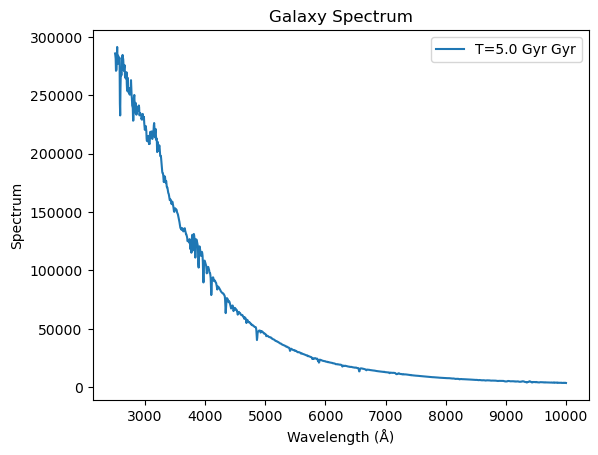

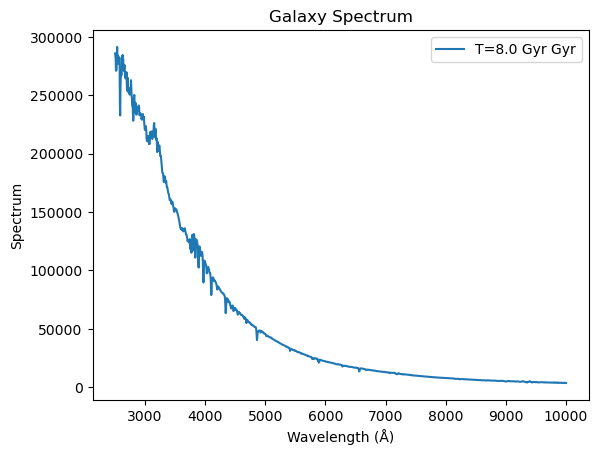

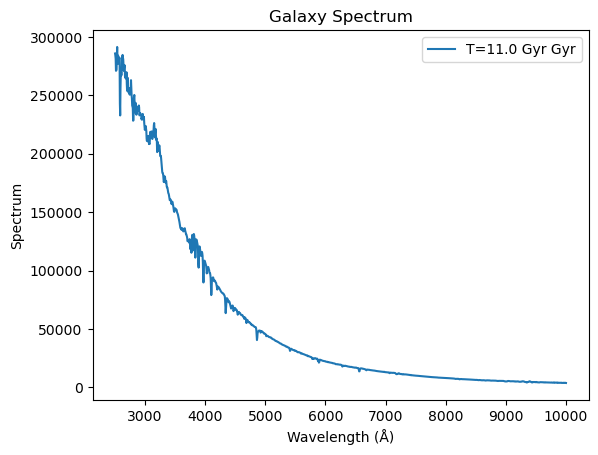

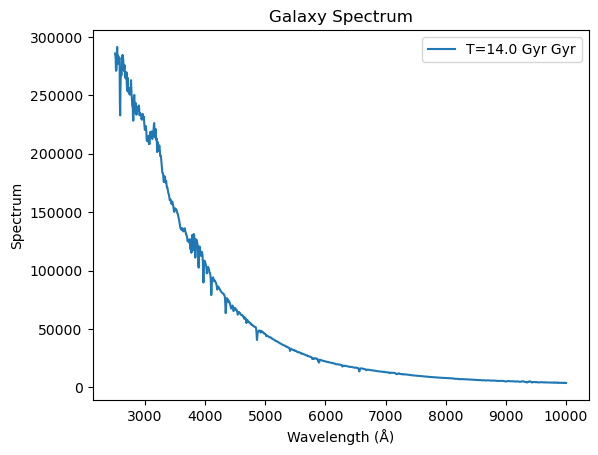

In [81]:
# galaxy = GALAXY(M=1e10, min_mass=0.1, max_mass=100)
# print(galaxy.Star_Formation(t=0, delta=0.01)) 

SFR_1 = [0.80, 0.15, 0.05]
t_SF_1 = [3, 4, 20]
ages = np.arange(0, 14, 0.1)
SFR = np.zeros_like(ages)

def modeldisplay(SFR,t):

    def displayGG(gal, t, rang=[2500, 10000]):
        global wavelength_O
    
        range_lb = (wavelength_O >= rang[0]) & (wavelength_O <= rang[1])
    
        for i in range(len(t)):
            gal.update_gal(t[i])
            plt.plot(wavelength_O[range_lb], gal.spectrum[range_lb], label=f'T={t[i]} Gyr')
            plt.xlabel('Wavelength (Å)')
            plt.ylabel('Spectrum')
            plt.title('Galaxy Spectrum')
            plt.legend()
            plt.show()

    tanalysis= [5,8,11,14]

    gal = GALAXY(M=1e10, min_mass=0.1, max_mass=100)

    for i in range(len(SFR)):
        gal.Star_Formation(t[i],0.01,SFR[i])
    
    displayGG(gal,tanalysis*u.Gyr)


modeldisplay(SFR_1,t_SF_1)


# for i in range(len(t_SF_1)):
#     idx = np.argmin(np.abs(ages - t_SF_1[i]))
#     ages[idx] = t_SF_1[i]
#     SFR[idx] = SFR_1[i]

# # Set star formation rates and ages in the galaxy object
# galaxy.set_star_formation_rates(SFR, ages)

# # Plot star formation rates using the GALAXY class method
# galaxy.plot_star_formation_rates()

# for i in range(len(SFR_1)):
#     galaxy.Star_Formation(t_SF_1[i],0.01,SFR_1[i])
    
# for t in t_SF_1:
#     galaxy.update_gal(t * u.Gyr)  # Update the galaxy state

#     # Example: Plotting the galaxy's spectrum after update
#     plt.figure(figsize=(10, 5))
#     plt.plot(wavelength_O,galaxy.spectrum)  # Adjust based on what `spectrum` represents in your class
#     plt.xlabel('Wavelength')
#     plt.ylabel('Flux')
#     plt.title(f'Galaxy Spectrum at t={t}')
#     plt.show()


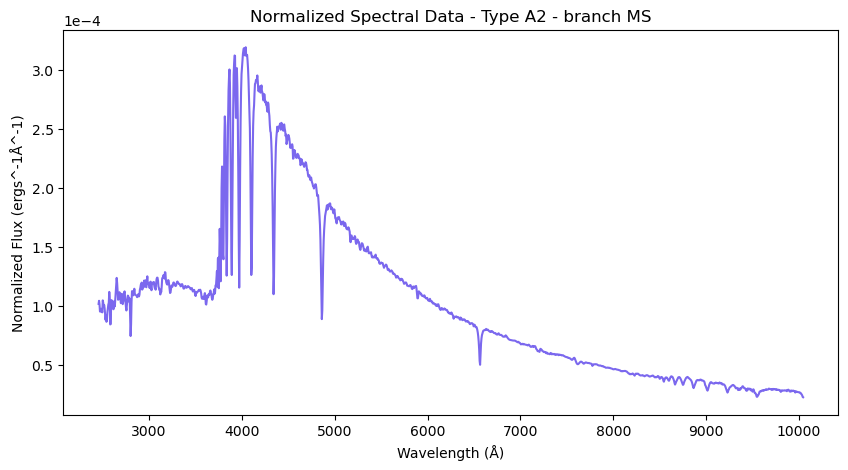

In [46]:
STAR(2,0,1).plot()

SFH random, 10 secciones, importante, cada SFH va a tener distintas poblaciones, la idea es que todas las poblaciones evolucionen al mismo timepo, entregarle el timepo la fraccion: 

la fraccion que corresponde a la cantidad de gas, como estas utilizanod el gas para la galaxia, mulmass*fraccion de gas. 
Espectros y SFH,
lo unico que intersa de la SFH es la edad. 
medir edad al final de universo, ahora, decir que estamos midiendo gLAXIas cercanas, son galaxias cercanas.
datos generados sean lo mas uniforme posible en edades.

cuantos datos de galaxia? no más allá de 10.000 
entre 0 y 05 

30 min todos los datos,

test: Crear una unica poblacion y evolucionarla
darle tiempo en que nacio.
ver el espectro, despues de 
por conveniencia elegir 0. en t y vemos que pasa con el espectro. 




# PRUEBAS RANDOM MALAS ABAJO

In [139]:
import math

def calcsfr(mg):
    # Simple Schmidt-Kennicutt law, from Kennicutt (1998)
    # Here, mg is the gas surface density (in Msun pc^-2)
    logMg = math.log10(mg)
    logSFR = logMg * 1.4 - 3.5
    SFR = 1e-6 * 10**logSFR
    return SFR

# Example gas surface density
mg = 100000  # Msun pc^-2
sfr = calcsfr(mg)
print(f'Star Formation Rate: {sfr} Msun yr^-1')


Star Formation Rate: 0.0031622776601683794 Msun yr^-1


In [53]:
# Generar una SFH simple


# Integrar la SFH para obtener el SFR en diferentes épocas
def generate_sfh(times, tau=3):
    def simple_sfh(time, tau=5):
        return np.exp(-time / tau)
    sfr = simple_sfh(times, tau)
    return sfr

# Ejemplo de uso
n_stars = 1000
# initial_masses = generate_initial_masses(n_stars)
times = np.linspace(0, 14, 20)  # 14 Gyr
sfh = generate_sfh(times)

# Interpolación para obtener la SFR en cualquier tiempo
sfh_interp = interp1d(times, sfh, kind='cubic')

sfh

array([1.        , 0.78222408, 0.61187451, 0.47862297, 0.37439041,
       0.2928572 , 0.22907995, 0.17919185, 0.14016818, 0.10964293,
       0.08576534, 0.06708771, 0.05247762, 0.04104926, 0.03210972,
       0.025117  , 0.01964712, 0.01536845, 0.01202157, 0.00940356])

Mass Range: [  0.3   0.4   0.5 ... 119.8 119.9 120. ]
Fractions: [3.21938017e-01 1.76445597e-01 1.09510995e-01 ... 3.47242967e-07
 3.46562482e-07 3.45883896e-07]


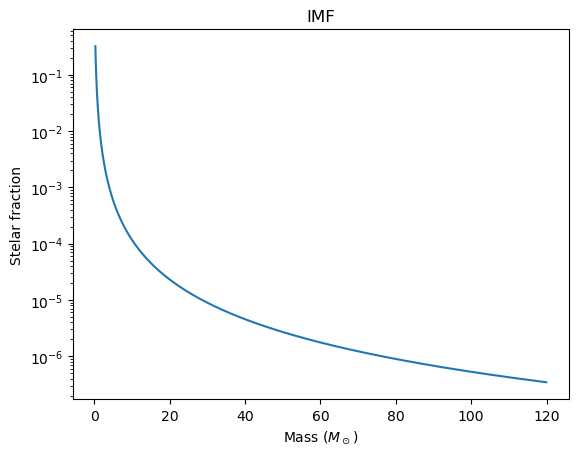

In [115]:
# Example usage
imf = IMF_salpeter()
delta = 0.1
mass_range, fractions = imf.generate_imf(delta)

print("Mass Range:", mass_range)
print("Fractions:", fractions)

# Plot the IMF
plt.plot(mass_range[:-1], fractions)
plt.yscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Stelar fraction')
plt.title('IMF')
plt.show()

Mass Range: [  0.3   0.4   0.5 ... 119.8 119.9 120. ]
Fractions: [3.21938017e-01 1.76445597e-01 1.09510995e-01 ... 3.47242967e-07
 3.46562482e-07 3.45883896e-07]


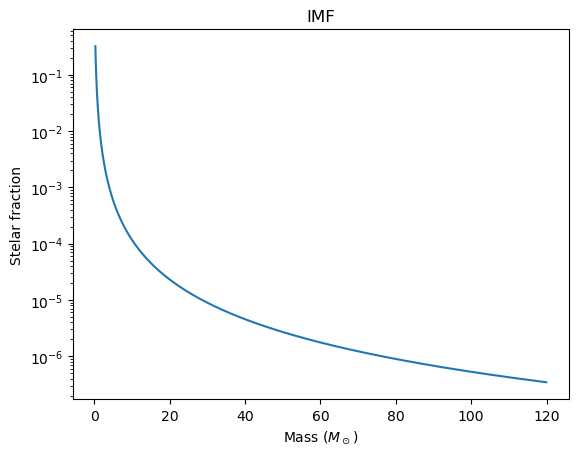

In [131]:
# Example usage
imf = IMF_salpeter()
delta = 0.1
mass_range, fractions = imf.generate_imf(delta)

print("Mass Range:", mass_range)
print("Fractions:", fractions)

# Plot the IMF
plt.plot(mass_range[:-1], fractions)
plt.yscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Stelar fraction')
plt.title('IMF')
plt.show()

In [133]:
len(mass_range)

1198

In [112]:
print("Mass Range:", mass_range)
print("Fractions:", fractions)
sum(fractions)

Mass Range: [  0.3   0.4   0.5 ... 119.8 119.9 120. ]
Fractions: [3.21938017e-01 1.76445597e-01 1.09510995e-01 ... 3.47242967e-07
 3.46562482e-07 3.45883896e-07]


1.0000000000000002

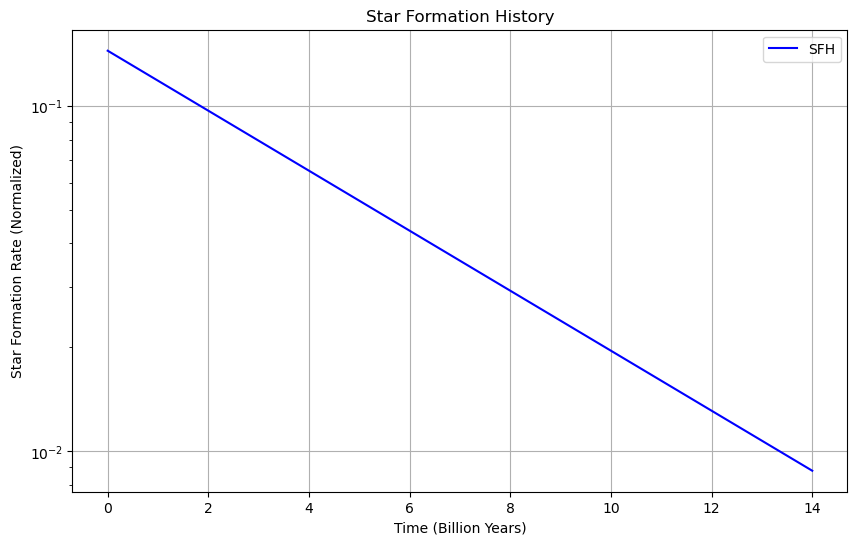

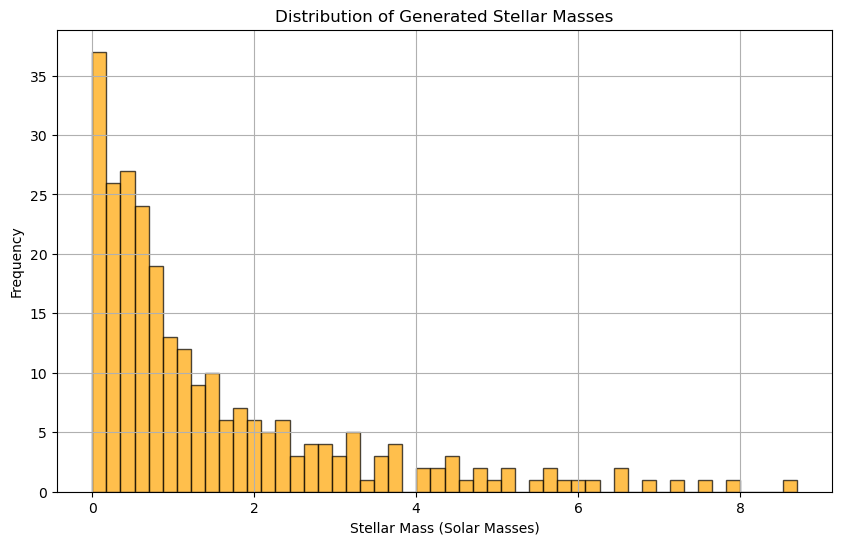

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate

class IMF_salpeter:
    default_mmin = 0.3
    default_mmax = 120

    def __init__(self, alpha=2.35, mmin=None, mmax=None):
        self._mmin = self.default_mmin if mmin is None else mmin
        self._mmax = self.default_mmax if mmax is None else mmax
        self.alpha = alpha
        self.slope = -alpha

        if not (0 < self._mmin < self._mmax):
            raise ValueError("mmin must be greater than 0 and less than mmax")
        if self._mmin == -1:
            raise ValueError("mmin cannot be -1")

        self.normalization_factor = self.calculate_normalization_factor()

    def calculate_normalization_factor(self):
        integral, _ = scipy.integrate.quad(self.raw_pdf, self._mmin, self._mmax)
        return 1.0 / integral

    def raw_pdf(self, x):
        return x ** self.slope

    def pdf(self, x):
        in_range = (x >= self._mmin) & (x <= self._mmax)
        return np.where(in_range, self.normalization_factor * x**self.slope, 0)

    def generate_masses(self, delta, sfr):
        mass_range = np.arange(self._mmin, self._mmax + delta, delta)
        masses = mass_range * sfr
        return masses

    def __call__(self, m):
        return self.pdf(m)

# Function to generate the SFH based on an exponential decline model
def generate_sfh(times, tau=5):
    def simple_sfh(time, tau):
        return np.exp(-time / tau)
    sfr = simple_sfh(times, tau)
    return sfr

# Example usage
n_stars = 10
times = np.linspace(0, 14, 20)  # 14 Gyr

# Generate the SFH
tau_sfh = 5  # Characteristic time scale in billions of years
sfh = generate_sfh(times, tau=tau_sfh)

# Normalize the SFH
sfh = sfh / np.sum(sfh)

# Plot the SFH
plt.figure(figsize=(10, 6))
plt.plot(times, sfh, label='SFH', color='blue')
plt.xlabel('Time (Billion Years)')
plt.ylabel('Star Formation Rate (Normalized)')
plt.title('Star Formation History')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Interpolation to obtain the SFR at any given time
sfh_interp = interp1d(times, sfh, kind='cubic')
#ESTO AUN ESTA MEDIO MALO!

# Generate SFRs using the interpolated SFH (assuming a total SFR of 1 solar mass per year)
total_sfr = 0.5  # Total star formation rate in solar masses per year
sfr = sfh_interp(times) * total_sfr

# # Plot the interpolated SFR
# plt.figure(figsize=(10, 6))
# plt.plot(times, sfr, label='Interpolated SFR', color='green')
# plt.xlabel('Time (Billion Years)')
# plt.ylabel('Star Formation Rate (Solar Masses per Year)')
# plt.title('Star Formation Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# Generate stellar masses using the IMF
imf = IMF_salpeter(alpha=2.35)
delta_mass = 10 # Mass resolution
stellar_masses = []

# Generate masses for each time step in the interpolated SFR
for sfr_value in sfr:
    masses = imf.generate_masses(delta_mass, sfr_value)
    stellar_masses.extend(masses)

# Convert the list to a numpy array for analysis
stellar_masses = np.array(stellar_masses)

# Plot the histogram of generated stellar masses
plt.figure(figsize=(10, 6))
plt.hist(stellar_masses, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Frequency')
plt.title('Distribution of Generated Stellar Masses')
plt.grid(True)
plt.yscale
plt.show()


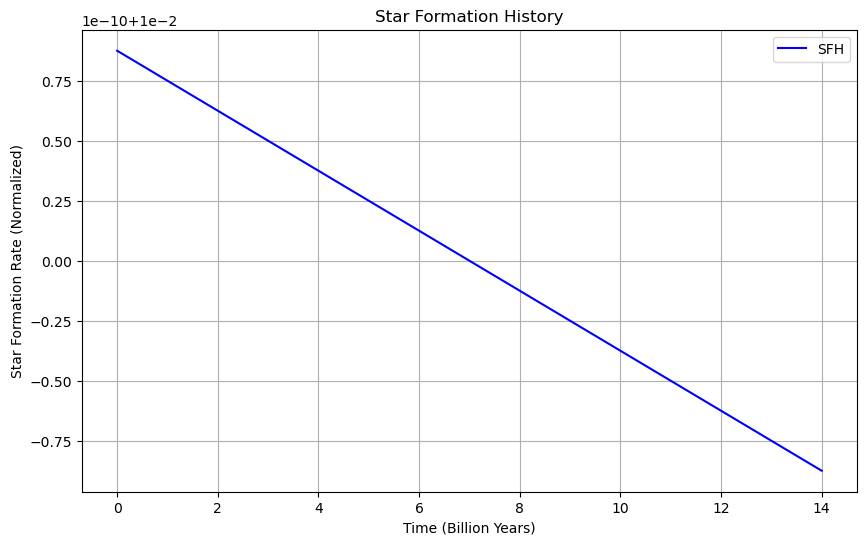

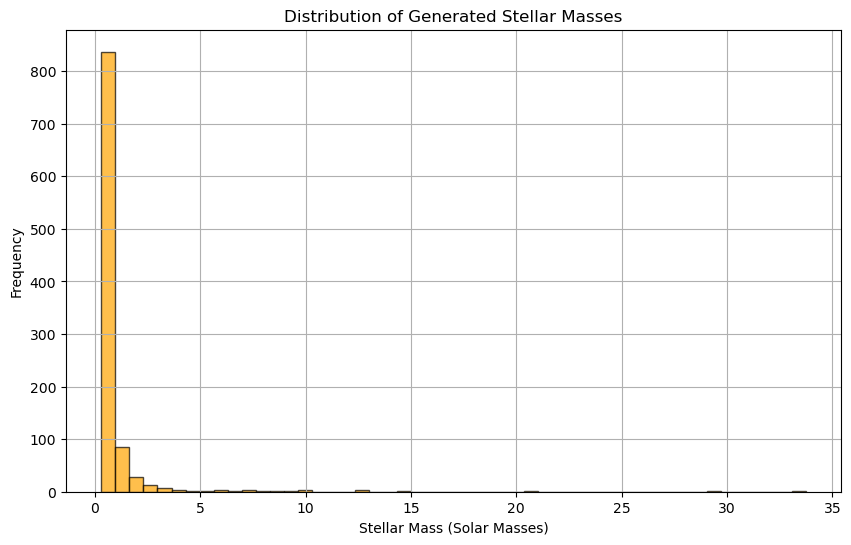

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate

class IMF_salpeter:
    default_mmin = 0.3
    default_mmax = 120

    def __init__(self, alpha=2.35, mmin=None, mmax=None):
        self._mmin = self.default_mmin if mmin is None else mmin
        self._mmax = self.default_mmax if mmax is None else mmax
        self.alpha = alpha
        self.slope = -alpha

        if not (0 < self._mmin < self._mmax):
            raise ValueError("mmin must be greater than 0 and less than mmax")
        if self._mmin == -1:
            raise ValueError("mmin cannot be -1")

        self.normalization_factor = self.calculate_normalization_factor()

    def calculate_normalization_factor(self):
        integral, _ = scipy.integrate.quad(self.raw_pdf, self._mmin, self._mmax)
        return 1.0 / integral

    def raw_pdf(self, x):
        return x ** self.slope

    def pdf(self, x):
        in_range = (x >= self._mmin) & (x <= self._mmax)
        return np.where(in_range, self.normalization_factor * x**self.slope, 0)

    def generate_masses(self, n_stars, sfr):
        cumulative_sfr = np.cumsum(sfr)
        cumulative_sfr /= cumulative_sfr[-1]  # Normalize 
        random_numbers = np.random.random(n_stars)
        time_bins = np.searchsorted(cumulative_sfr, random_numbers)
        masses = []

        for i in time_bins:
            mass_range = np.linspace(self._mmin, self._mmax, n_stars)
            prob_distribution = self.pdf(mass_range)
            prob_distribution /= np.sum(prob_distribution)  # Normalize
            selected_mass = np.random.choice(mass_range, p=prob_distribution)
            masses.append(selected_mass)

        return np.array(masses)

    def __call__(self, m):
        return self.pdf(m)

# Function to generate the SFH based on an exponential decline model
def generate_sfh(times, tau=5):
    def simple_sfh(time, tau):
        return np.exp(-time / tau)
    sfr = simple_sfh(times, tau)
    return sfr

# Example usage
n_stars = 1000
times = np.linspace(0, 14, 100)  # 14 Gyr

# Generate the SFH
tau_sfh = 8.e+8  # Characteristic time scale in billions of years
sfh = generate_sfh(times, tau=tau_sfh)

# Normalize the SFH
sfh = sfh / np.sum(sfh)

# Plot the SFH
plt.figure(figsize=(10, 6))
plt.plot(times, sfh, label='SFH', color='blue')
plt.xlabel('Time (Billion Years)')
plt.ylabel('Star Formation Rate (Normalized)')
plt.title('Star Formation History')
plt.legend()
plt.grid(True)
plt.show()

# Interpolation to obtain the SFR at any given time
sfh_interp = interp1d(times, sfh, kind='cubic')

# Define the total SFR using observational data
sfr = calcsfr(mg) # Example: Total star formation rate in solar masses per year
total_sfr = .10

# Generate SFRs using the interpolated SFH
sfr = sfh_interp(times) * total_sfr

# Plot the interpolated SFR
# plt.figure(figsize=(10, 6))
# plt.plot(times, sfr, label='Interpolated SFR', color='green')
# plt.xlabel('Time (Billion Years)')
# plt.ylabel('Star Formation Rate (Solar Masses per Year)')
# plt.title('Star Formation Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# Generate stellar masses using the IMF
imf = IMF_salpeter(alpha=2.35)
stellar_masses = imf.generate_masses(n_stars, sfr)

# Plot the histogram of generated stellar masses
plt.figure(figsize=(10, 6))
plt.hist(stellar_masses, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Frequency')
plt.title('Distribution of Generated Stellar Masses')
plt.grid(True)
plt.show()


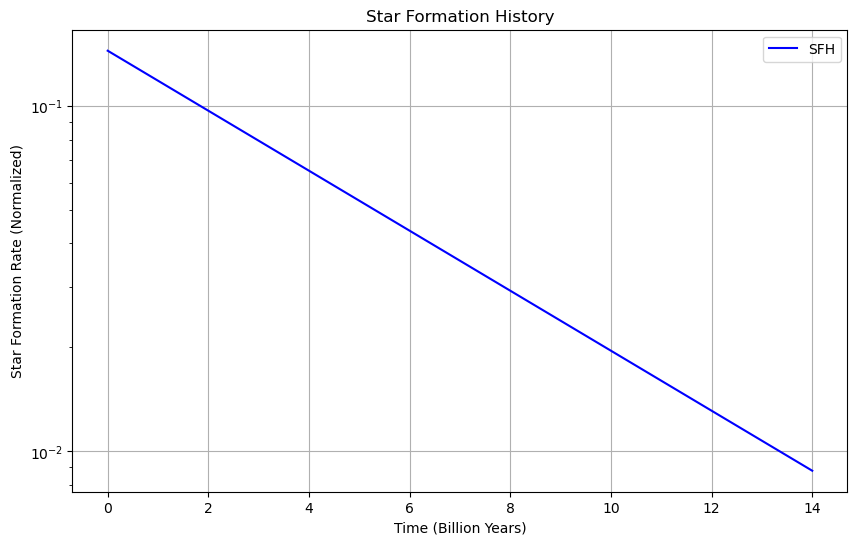

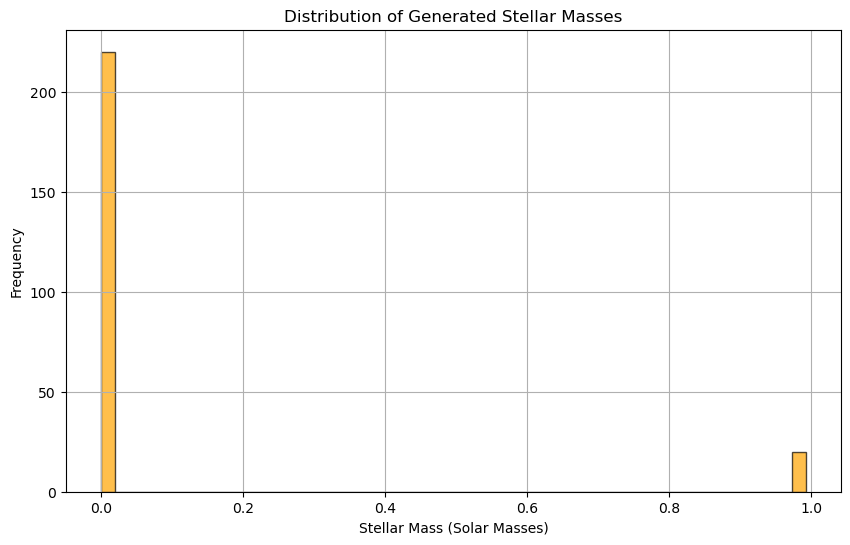

In [128]:
# Example usage
n_stars = 10
times = np.linspace(0, 14, 20)  # 14 Gyr

# Generate the SFH
tau_sfh = 5  # Characteristic time scale in billions of years
sfh = generate_sfh(times, tau=tau_sfh)

# Normalize the SFH
sfh = sfh / np.sum(sfh)

# Plot the SFH
plt.figure(figsize=(10, 6))
plt.plot(times, sfh, label='SFH', color='blue')
plt.xlabel('Time (Billion Years)')
plt.ylabel('Star Formation Rate (Normalized)')
plt.title('Star Formation History')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Interpolation to obtain the SFR at any given time
sfh_interp = interp1d(times, sfh, kind='cubic')
#ESTO AUN ESTA MEDIO MALO!

# Generate SFRs using the interpolated SFH (assuming a total SFR of 1 solar mass per year)
total_sfr = 0.5  # Total star formation rate in solar masses per year
sfr = sfh_interp(times) * total_sfr

# # Plot the interpolated SFR
# plt.figure(figsize=(10, 6))
# plt.plot(times, sfr, label='Interpolated SFR', color='green')
# plt.xlabel('Time (Billion Years)')
# plt.ylabel('Star Formation Rate (Solar Masses per Year)')
# plt.title('Star Formation Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# Generate stellar masses using the IMF
# imf = IMF_salpeter()
delta_mass = 10 # Mass resolution
stellar_masses = []

# Generate masses for each time step in the interpolated SFR
for sfr_value in sfr:
    stellar_masses.extend(fractions)

# Convert the list to a numpy array for analysis
stellar_masses = np.array(stellar_masses)

# Plot the histogram of generated stellar masses
plt.figure(figsize=(10, 6))
plt.hist(stellar_masses, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Frequency')
plt.title('Distribution of Generated Stellar Masses')
plt.grid(True)
plt.yscale
plt.show()